**Z. IMPORTS**

In [993]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import matplotlib.artist as ar
import seaborn as sns
from wordcloud import WordCloud as wc
import os

src = pd.read_csv("googleplaystore.csv")
rvw = pd.read_csv("googleplaystore_user_reviews.csv")
and_version = pd.read_csv("Android Versions.csv")

**A. BASIC DESCRIPTION OF DATA - PRE CLEANING**

In [994]:
src.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

In [995]:
src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [996]:
src.App.nunique()

9660

In [997]:
src.shape

(10841, 13)

**B.1. CLEANING**

1. Converting install count from a string to a number

In [998]:
#Clean up numbers by removing trailing + and commas between thousands
src["Installs"] = src["Installs"].str.replace("+","")
src["Installs"] = src["Installs"].str.replace(",","")
#Delete the stray row that has invalid data in this field
src = src[src.Installs != "Free"]
#Convert to an int
src["Installs"] = src["Installs"].astype("int")

C:\Users\Mrin\AppData\Local\Temp\ipykernel_37728\1834220106.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  src["Installs"] = src["Installs"].str.replace("+","")


2. Size column and it converting everything possible to int KBs

In [999]:
#null out varies with size in a holding variable
cleanedsize = src["Size"].replace("Varies with device",np.NaN)
#ditch our k and m letters in our holding tank
cleanedsize = np.where(cleanedsize.str.contains('M',regex=False),cleanedsize.str.replace("M",""), cleanedsize.str.replace("k",""))
#create new KB size column as a float
src["KB Size"] = cleanedsize.astype("float")
#Multiply anything in megabytes by 1000
src["KB Size"] = np.where(src["Size"].str.contains('M',regex=False), src["KB Size"] * 1000, src["KB Size"])

3. Price, Type, and Reviews Variables

In [1000]:
src['Price'] = src['Price'].replace('[\$,]', '', regex=True)
src["Price"] = src["Price"].astype("float")
src['Type'].fillna("Free",inplace=True)
src["Reviews"] = src["Reviews"].astype("int")
src["Last Updated"] = src["Last Updated"].astype("datetime64")

4. Calculate Android Ver variable

In [1001]:
src["Android Ver"] = src["Android Ver"].str.replace(" and up","") #remove and up
src["Android Ver"].replace(to_replace= np.NaN, value = "Unspecified", inplace=True) #replace NaN with Unspecified
src[["Minimum Version", "Maximum Version"]] = src["Android Ver"].str.split(" - ", expand = True) #split versions to min and max version supported
src["Maximum Version"] = np.where(src["Minimum Version"] == "Unspecified", "Unspecified", src["Maximum Version"]) #if min version is unspecified then max version should be unspecified
src["Maximum Version"].replace(to_replace= [None], value = "Latest", inplace = True) #else max version is latest version
src.pop("Android Ver") #remove the Android Version

0                     4.0.3
1                     4.0.3
2                     4.0.3
3                       4.2
4                       4.4
                ...        
10836                   4.1
10837                   4.1
10838                   2.2
10839    Varies with device
10840    Varies with device
Name: Android Ver, Length: 10840, dtype: object

5. Update Android Version Names

In [1002]:
src["Minimum Version"] = src["Minimum Version"].astype("str")
src["Maximum Version"] = src["Maximum Version"].astype("str")
and_version.astype({"Minimum Version":"str"}) #change type to string
src["Minimum Version"] = src["Minimum Version"].map(and_version.set_index("Minimum Version")["Name"]) #update min version supported with name
src["Maximum Version"] = src["Maximum Version"].map(and_version.set_index("Minimum Version")["Name"]) #update max version supported with name

6. Drop duplicates

In [1003]:
src.drop_duplicates(["App","Category","Size", "Installs"],keep="first",inplace=True) #drop duplicates based on 4 composite keys

**B.2 DATA DESCRIPTION AFTER CLEANING**

In [1004]:
src.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'KB Size', 'Minimum Version', 'Maximum Version'],
      dtype='object')

In [1005]:
src.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9756 entries, 0 to 10840
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   App              9756 non-null   object        
 1   Category         9756 non-null   object        
 2   Rating           8291 non-null   float64       
 3   Reviews          9756 non-null   int32         
 4   Size             9756 non-null   object        
 5   Installs         9756 non-null   int32         
 6   Type             9756 non-null   object        
 7   Price            9756 non-null   float64       
 8   Content Rating   9756 non-null   object        
 9   Genres           9756 non-null   object        
 10  Last Updated     9756 non-null   datetime64[ns]
 11  Current Ver      9748 non-null   object        
 12  KB Size          8505 non-null   float64       
 13  Minimum Version  9756 non-null   object        
 14  Maximum Version  9756 non-null   object

In [1006]:
src.App.nunique()

9659

In [1007]:
src.shape

(9756, 15)

**C. BASIC ANALYSIS**

1. Exploration of Numberical Variables

d:\Installation_Files\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1, 'Basic Data Exploration by App Type [Free vs. Paid]')

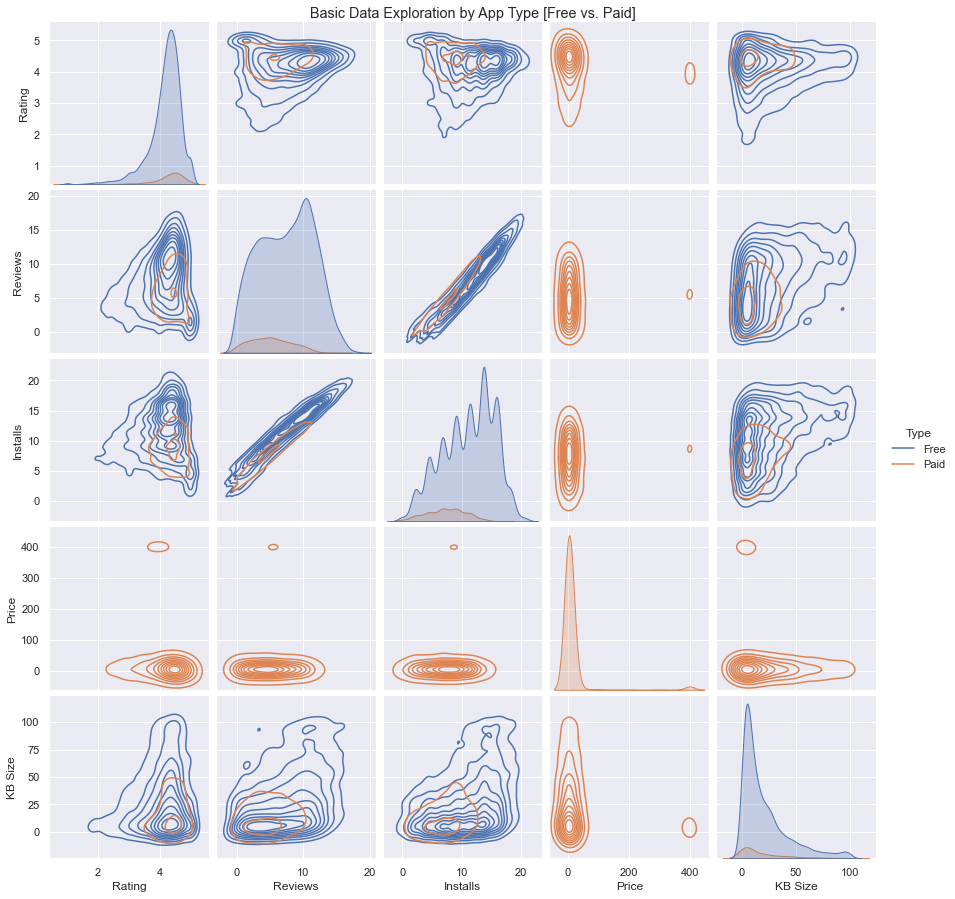

In [1008]:
a = src["Rating"]
b = np.log(src["Reviews"])
c = np.log(src["Installs"])
d = src["Price"]
e = (src["KB Size"])/1000
f = src["Type"]

g = sns.pairplot(pd.DataFrame(list(zip(a,b,c,d,e,f)), columns=["Rating","Reviews", "Installs","Price", "KB Size","Type"]), hue="Type", kind = "kde", diag_kind = "auto")
g.fig.suptitle("Basic Data Exploration by App Type [Free vs. Paid]", y = 1)


**D. OVERALL RATING ANALYSIS**

1. Distribution of Ratings across apps on the store

Average app rating on the play store is:  4.175189965022318


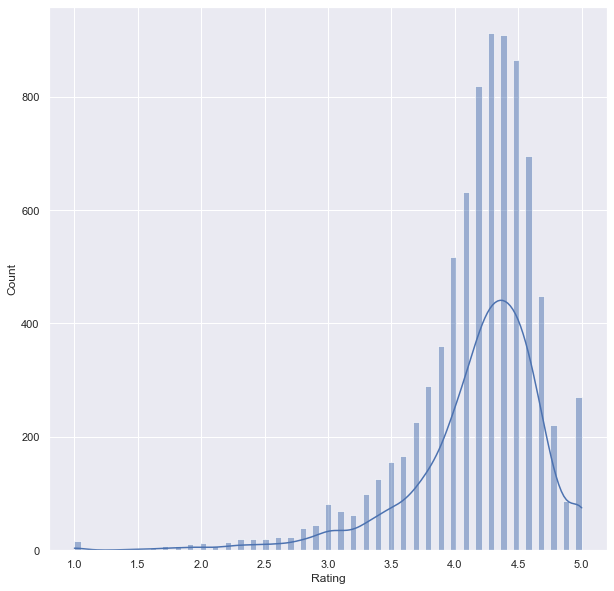

In [1009]:
plt.figure(figsize=(10,10))
sns.histplot(src.Rating, kde=True)#.set(xlim = (0,20))
print("Average app rating on the play store is: ",src.Rating.mean())

2. Basic boxplot for Rating across Free and Paid Apps

[Text(0.5, 1.0, 'Boxplot for Rating across Free and Paid Apps')]

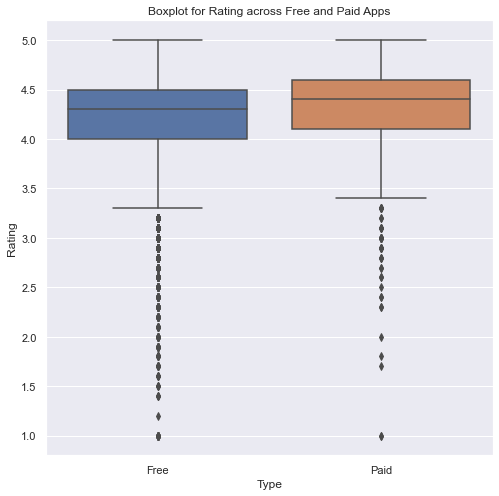

In [1010]:
plt.figure(figsize=(8,8))
sns.boxplot(x="Type",y="Rating",data = src).set(title = "Boxplot for Rating across Free and Paid Apps")

3. Basic Statistics by Free and Paid Apps

In [1011]:
ispaid = src.groupby("Type")
ispaid.agg({"Rating": ["mean","median","std"], "Installs":["mean","median","std"], "Reviews":["mean","median","std"], "Price":["mean","median","std"], "KB Size":["mean","median","std"]}).round(2)

Rating                 Installs                           Reviews  \
       mean median   std        mean    median          std       mean   
Type                                                                     
Free   4.17    4.3  0.53  8888862.37  100000.0  57474470.77  257220.61   
Paid   4.26    4.4  0.56    76340.21    1000.0    538499.29    8742.92   

                          Price                 KB Size                     
      median         std   mean median    std      mean   median       std  
Type                                                                        
Free  1467.0  2011659.91   0.00   0.00   0.00  20647.80  12000.0  21912.27  
Paid    88.0    89771.54  14.02   2.99  58.67  19056.19   9400.0  22173.08

4. Scatterplot of Rating Vs. Size for Paid Apps

Text(0.5, 1.0, 'Rating Vs. Size for Paid Apps')

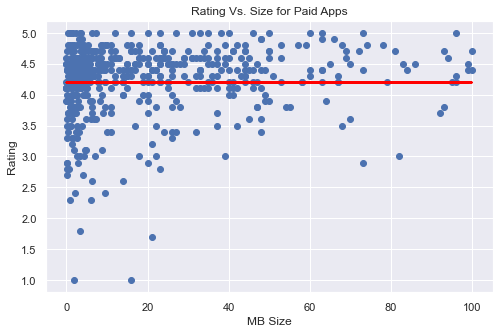

In [1012]:
plt.figure(figsize=(8,5))

dropnas = src[["Rating","KB Size","Type"]].dropna(how="any", inplace=False)
#plt.scatter(dropnas["KB Size"]/1000, dropnas["Rating"])
plt.scatter(dropnas[dropnas["Type"] == "Paid"]["KB Size"]/1000, dropnas[dropnas["Type"] == "Paid"]["Rating"])

m, b = np.polyfit(dropnas[dropnas["Type"] == "Paid"]["KB Size"]/1000, dropnas[dropnas["Type"] == "Paid"]["Rating"], 1)

plt.plot(dropnas[dropnas["Type"] == "Paid"]["KB Size"]/1000, m*dropnas[dropnas["Type"] == "Paid"]["Rating"]+b, color="red")
plt.xlabel("MB Size")
plt.ylabel("Rating")
plt.title("Rating Vs. Size for Paid Apps")

5. Scatterplot of Rating Vs. Size for All Apps

Text(0.5, 1.0, 'Rating Vs. Size for All Apps')

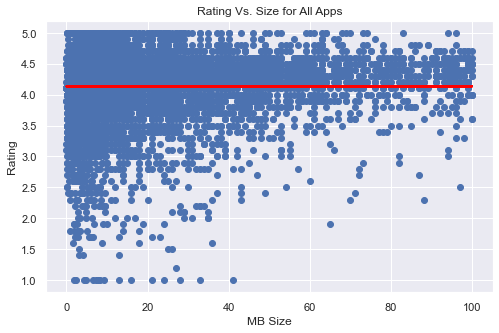

In [1013]:
plt.figure(figsize=(8,5))
plt.scatter(dropnas["KB Size"]/1000, dropnas["Rating"])
m, b = np.polyfit(dropnas["KB Size"]/1000, dropnas["Rating"], 1)

plt.plot(dropnas["KB Size"]/1000, m*dropnas["Rating"]+b, color="red")
plt.xlabel("MB Size")
plt.ylabel("Rating")
plt.title("Rating Vs. Size for All Apps")

**E. APP INSTALLS ANALYSIS**

1. Distribution of total number of installs

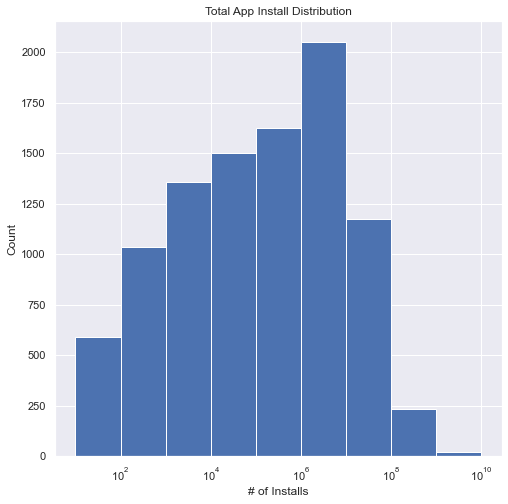

In [1014]:
plt.figure(figsize=(8,8))
plt.hist(src["Installs"], bins=np.logspace(start=np.log10(10), stop=np.log10(10000000000), num=10))
plt.xlabel("# of Installs")
plt.ylabel("Count")
plt.title("Total App Install Distribution")
plt.gca().set_xscale("log")
plt.show()

2. Distribution of total number of installs for Free Apps

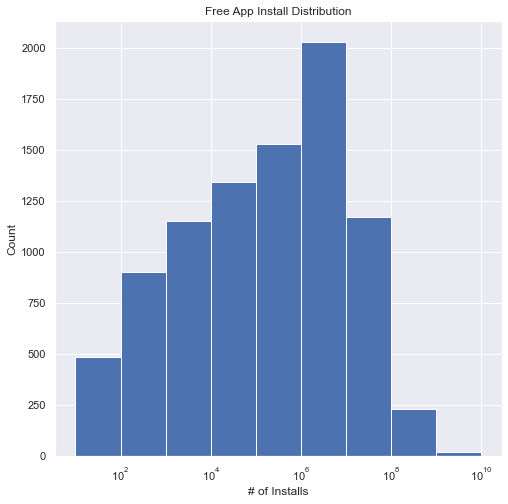

In [1015]:
plt.figure(figsize=(8,8))
plt.hist(src[src["Type"]=="Free"]["Installs"], bins=np.logspace(start=np.log10(10), stop=np.log10(10000000000), num=10))
plt.xlabel("# of Installs")
plt.ylabel("Count")
plt.title("Free App Install Distribution")
plt.gca().set_xscale("log")
plt.show()

3. Distribution of total number of installs for Free Apps

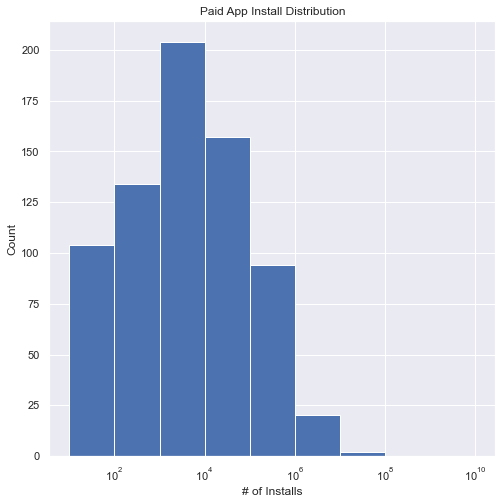

In [1016]:
plt.figure(figsize=(8,8))
plt.hist(src[src["Type"]=="Paid"]["Installs"], bins=np.logspace(start=np.log10(10), stop=np.log10(10000000000), num=10))
plt.xlabel("# of Installs")
plt.ylabel("Count")
plt.title("Paid App Install Distribution")
plt.gca().set_xscale("log")
plt.show()

4. Relationship between Size of Apps and Installs (On Log Scale)

d:\Installation_Files\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


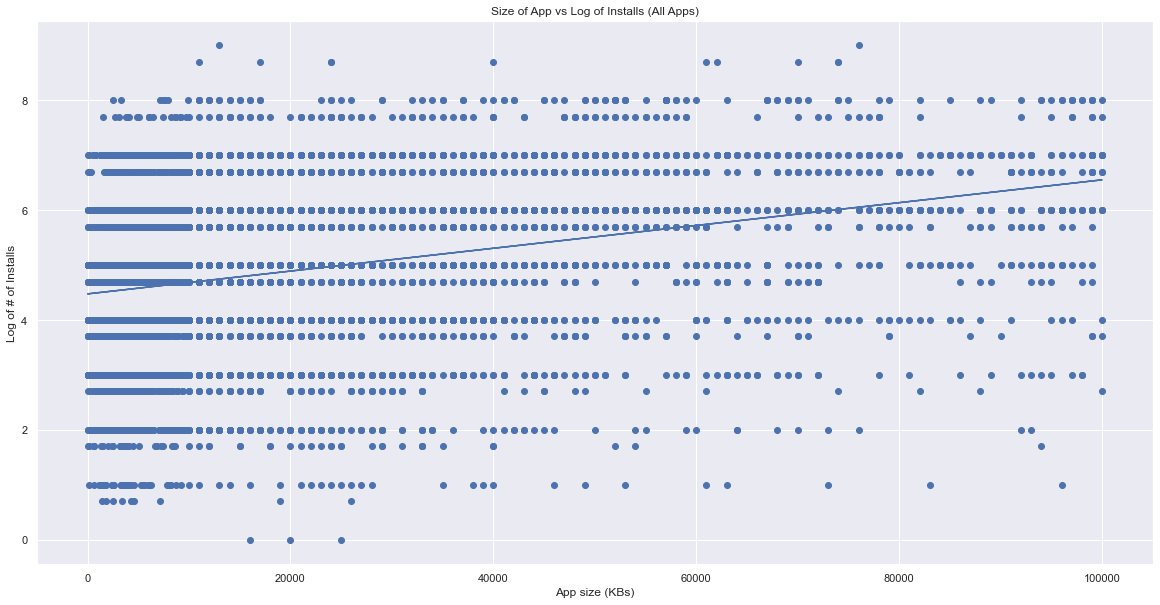

In [1017]:
plt.figure(figsize=(20,10))
src["Months since Last Update"] = ((src["Last Updated"].dt.year - 2018) + (src["Last Updated"].dt.month - 8)) * -1
src['Log Installs']= np.log10(src['Installs'])
corrsrc = src[["Months since Last Update","Log Installs","Rating","KB Size","Category"]].dropna(how="any", inplace=False)
#corrsrc = corrsrc[corrsrc["Category"]=="GAME"]
plt.scatter(corrsrc["KB Size"],corrsrc["Log Installs"])
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(corrsrc["KB Size"], corrsrc["Log Installs"], 1)

#add linear regression line to scatterplot
plt.plot(corrsrc["KB Size"], m*corrsrc["KB Size"]+b)
plt.xlabel("App size (KBs)")
plt.ylabel("Log of # of Installs")
plt.title("Size of App vs Log of Installs (All Apps)")
plt.show()

5. Relationship betweem Size of Game Apps and Installs (On Log Scale)

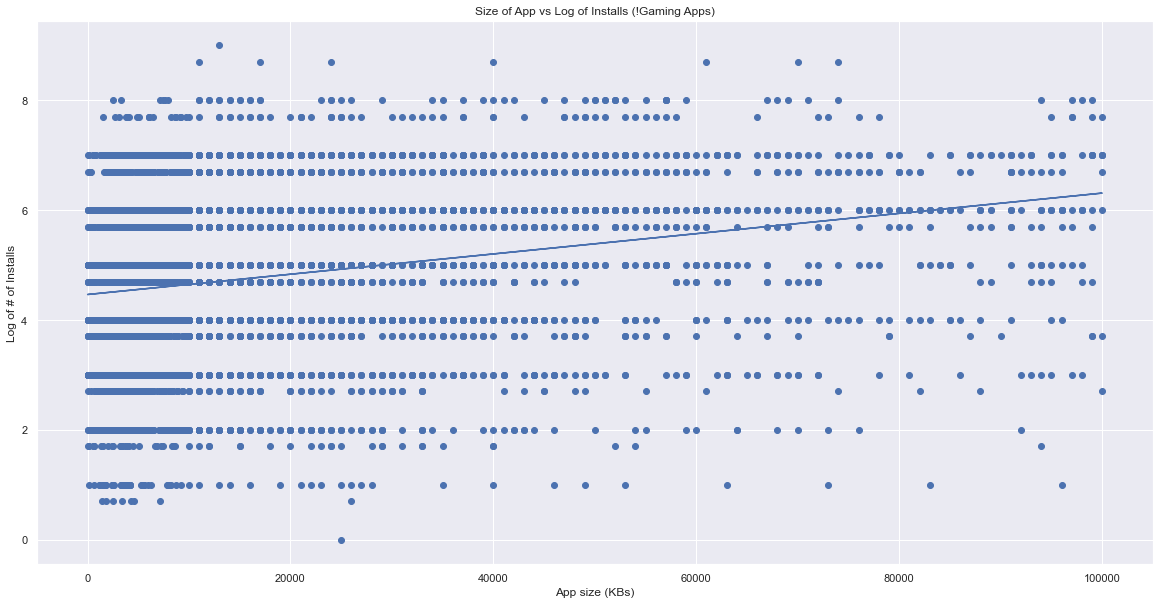

In [1018]:
plt.figure(figsize=(20,10))
corrsrc = src[["Months since Last Update","Log Installs","Rating","KB Size","Category"]].dropna(how="any", inplace=False)
corrsrc = corrsrc[corrsrc["Category"]!="GAME"]
plt.scatter(corrsrc["KB Size"],corrsrc["Log Installs"])
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(corrsrc["KB Size"], corrsrc["Log Installs"], 1)

#add linear regression line to scatterplot 
plt.plot(corrsrc["KB Size"], m*corrsrc["KB Size"]+b)
plt.xlabel("App size (KBs)")
plt.ylabel("Log of # of Installs")
plt.title("Size of App vs Log of Installs (!Gaming Apps)")
plt.show()

6. Relationship between Ratings and Number of Installs (Log)

C:\Users\Mrin\AppData\Local\Temp\ipykernel_37728\1341043411.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src2['Log Installs']= np.log10(src2['Installs'])


Text(0.5, 1.0, 'Installs vs Rating')

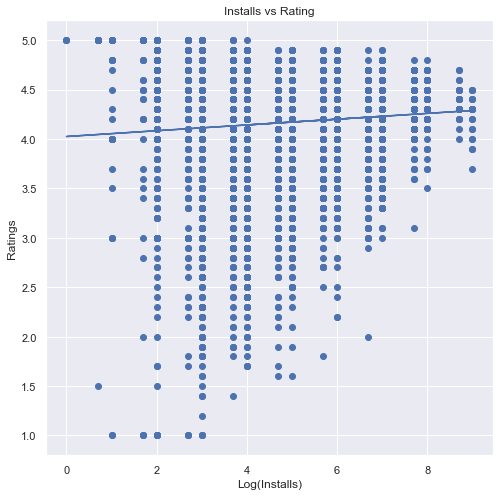

In [1019]:
#drop NaN for Rating and Installs column and copy it over to another df - src2
src2=src.dropna(subset=["Rating","Installs"])
#Add a new column with log(Installs) as its value
src2['Log Installs']= np.log10(src2['Installs'])

plt.figure(figsize=(8,8))
plt.scatter(src2['Log Installs'],src2['Rating'])

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(src2['Log Installs'],src2['Rating'], 1)

#add linear regression line to scatterplot
plt.plot(src2['Log Installs'], m*src2['Log Installs']+b)
plt.xlabel("Log(Installs)")
plt.ylabel("Ratings")
plt.title("Installs vs Rating")

Relationship between log(Installs) and log(Reviews)

Text(0.5, 1.0, 'Log(Reviews) Vs. Log(Installs)')

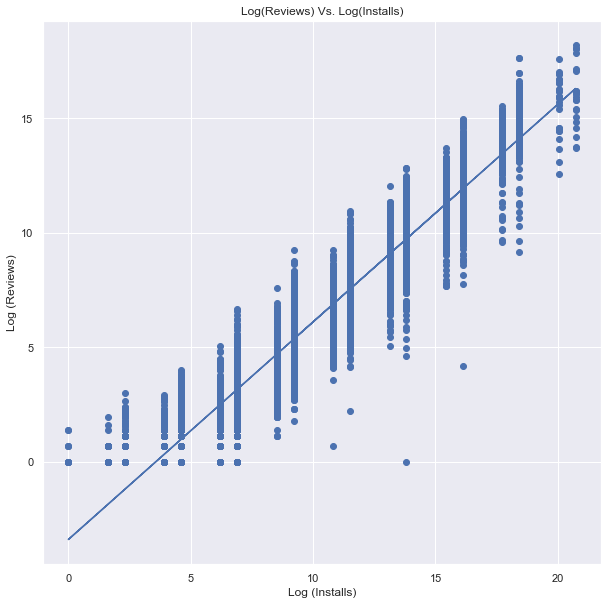

In [1020]:
src4 = src[["Reviews", "Installs"]].dropna(how = "any", inplace=False)
src4.drop(src4[src4["Reviews"] == 0].index, inplace = True)
src4.drop(src4[src4["Installs"]==0].index, inplace=True)
src4["Log Installs"] = np.log(src4["Installs"])
src4["Log Reviews"] = np.log(src4["Reviews"])

plt.figure(figsize=(10,10))
plt.scatter(src4["Log Installs"], src4["Log Reviews"])
m,b = np.polyfit(src4["Log Installs"], src4["Log Reviews"], 1)

plt.plot(src4["Log Installs"], m*src4["Log Installs"]+b)
plt.xlabel("Log (Installs)")
plt.ylabel("Log (Reviews)")
plt.title("Log(Reviews) Vs. Log(Installs)")

**F. ANDROID VERSION ANALYSIS**

1. Android Version vs Normalized Mean Rating

[Text(0, 0.5, 'Android Version'),
 Text(0.5, 0, 'Normalized Rating'),
 Text(0.5, 1.0, 'App Version vs. Normalized Rating')]

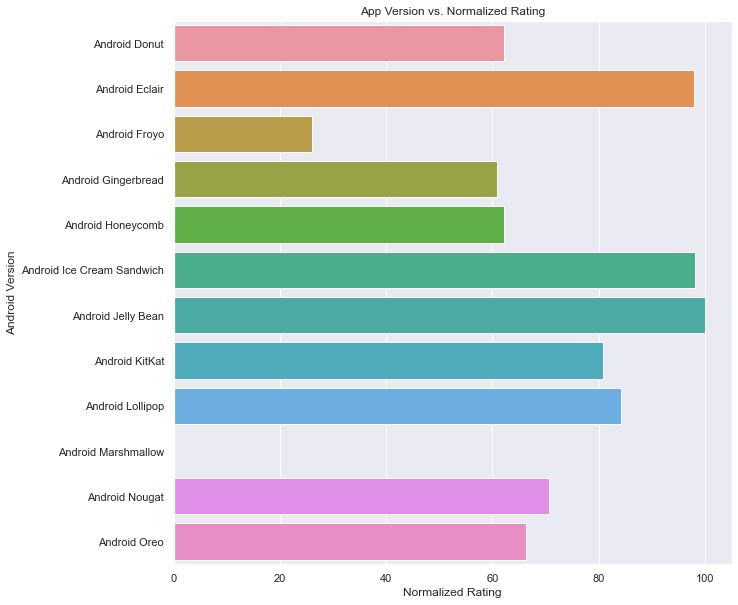

In [1021]:
plt.figure(figsize=(10,10))
med_rating = src.groupby("Minimum Version").Rating.mean().sort_values(ascending=True).to_frame()
med_rating.insert(0, "Name", med_rating.index)
med_rating = med_rating.merge(and_version, how = "inner", on = "Name")
med_rating.pop("Minimum Version")
med_rating.drop_duplicates(keep="first", inplace=True)
med_rating.reset_index(inplace = True, drop = True)
med_rating.sort_values("Rank", ascending=True, inplace=True)
med_rating = med_rating.iloc[2:,:]
med_rating["Normalized_Rating"] = (med_rating.Rating - med_rating.Rating.min())/(med_rating.Rating.max()-med_rating.Rating.min())*100
sns.barplot(x = med_rating.Normalized_Rating[2:], y = med_rating.Name[2:], orient="h").set(ylabel = "Android Version", xlabel = "Normalized Rating", title = "App Version vs. Normalized Rating")

2. Android Version vs App Installs

Text(0.5, 1.0, 'Android Version vs. App Installs')

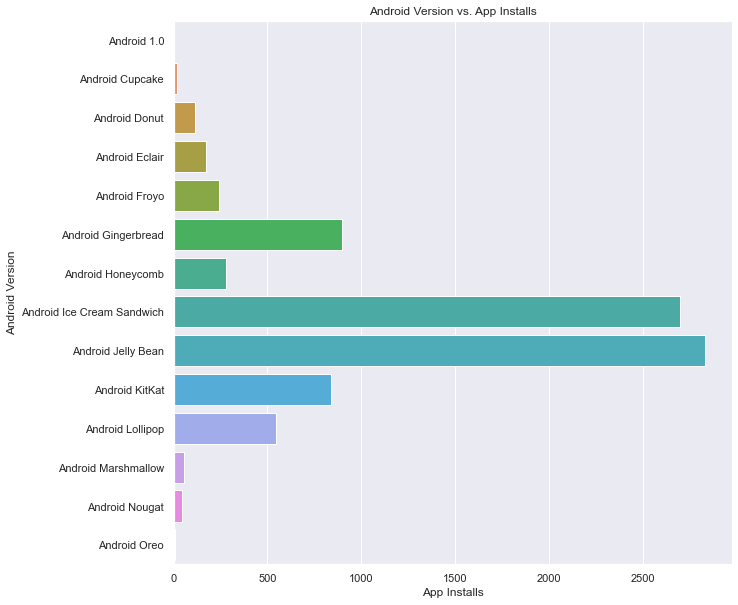

In [1022]:
values = src.groupby("Minimum Version").count()["App"].to_frame()
values.insert(0,"Name",values.index)
values = values.merge(and_version, how="inner", on = "Name")
values.pop("Minimum Version")
values.drop_duplicates(keep="first", inplace=True)
values.reset_index(inplace=True, drop=True)
values.sort_values("Rank", ascending=True, inplace=True)

plt.figure(figsize=(10,10))
sns.barplot(x = values.App[2:], y = values.Name[2:]).set(xlabel = "App Installs", ylabel = "Android Version")
plt.title("Android Version vs. App Installs")

**G. APP EXPLORATION**

1. Ratios of Paid and Free App

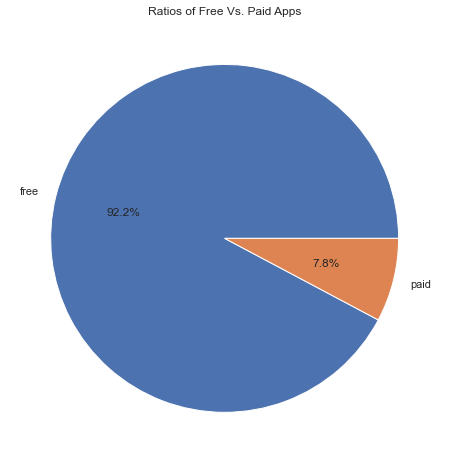

In [1023]:
plt.figure(figsize=(8,8))
plt.title("Ratios of Free Vs. Paid Apps")
plt.pie(src.Type.value_counts(), labels = ["free", "paid"], autopct = "%1.1f%%")
plt.show()

2. Top Free Apps by Install

Text(0.5, 1.0, 'Top Free Apps by Install')

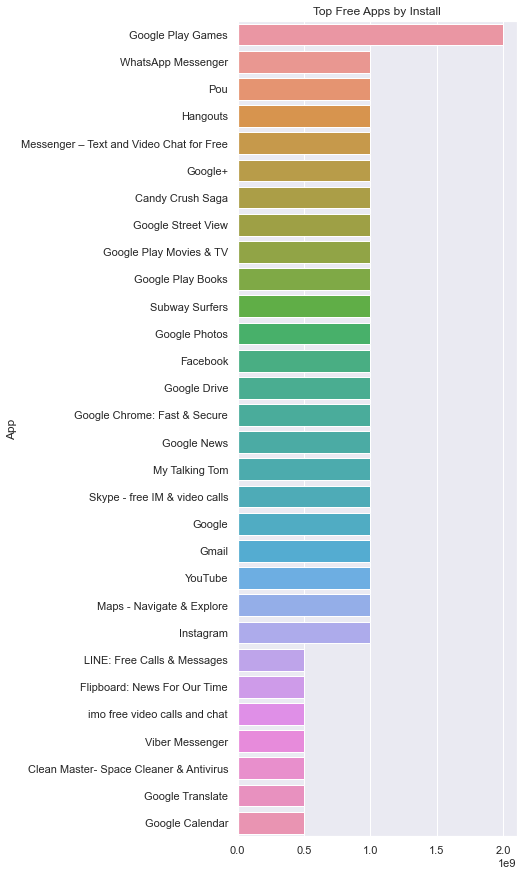

In [1024]:
free = src[src.Type == "Free"]
f = free.groupby("App").Installs.sum().sort_values(ascending = False).head(30)
plt.figure(figsize=(5,15))
sns.barplot(x = f.values, y = f.index)
plt.title("Top Free Apps by Install")
# f = f.to_frame()
# f.insert(0,"App Name",f.index)
# f.reset_index(inplace = True, drop = True)
# f.head(50)

3. Top Paid Apps by Install

Text(0.5, 1.0, 'Top Paid Apps by Install')

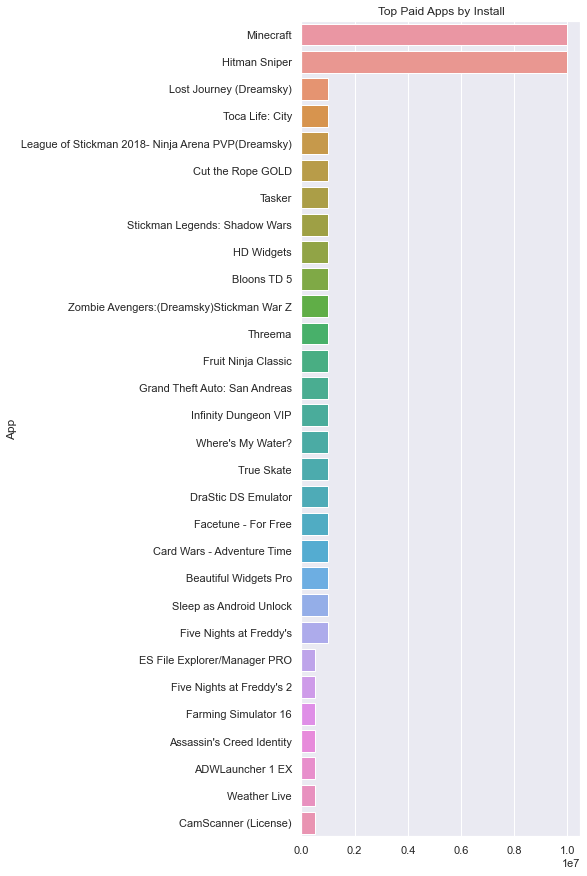

In [1025]:
free = src[src.Type == "Paid"]
f = free.groupby("App").Installs.sum().sort_values(ascending = False).head(30)
plt.figure(figsize=(5,15))
sns.barplot(x = f.values, y = f.index)
plt.title("Top Paid Apps by Install")
# f = f.to_frame()
# f.insert(0,"App Name",f.index)
# f.reset_index(inplace = True, drop = True)
# f.head(20)

4. Top Paid Apps by Price

[Text(0.5, 0, 'Price'),
 Text(0, 0.5, 'App Name'),
 Text(0.5, 1.0, 'Top Paid Apps by Price')]

d:\Installation_Files\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Installation_Files\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 25105 (\N{CJK UNIFIED IDEOGRAPH-6211}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Installation_Files\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24456 (\N{CJK UNIFIED IDEOGRAPH-5F88}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Installation_Files\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Installation_Files\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 37666 (\N{CJK UNIFIED IDEOGRAPH-9322}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


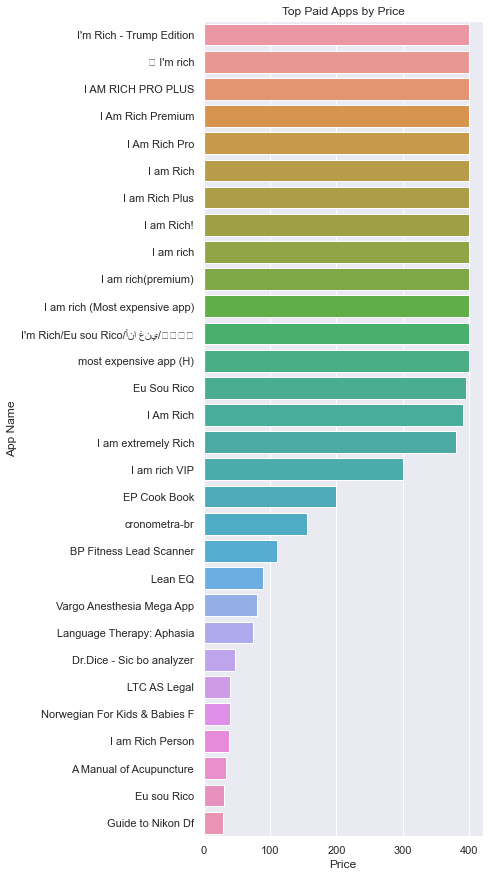

In [1026]:
p = free.groupby("App").Price.mean().sort_values(ascending=False).head(30)
plt.figure(figsize=(5,15))
sns.barplot(x = p.values, y = p.index).set(xlabel = "Price", ylabel = "App Name", title = "Top Paid Apps by Price")

5. Price Distribution of Paid Apps

Text(0.5, 1.0, 'Price Distribution of Paid Apps')

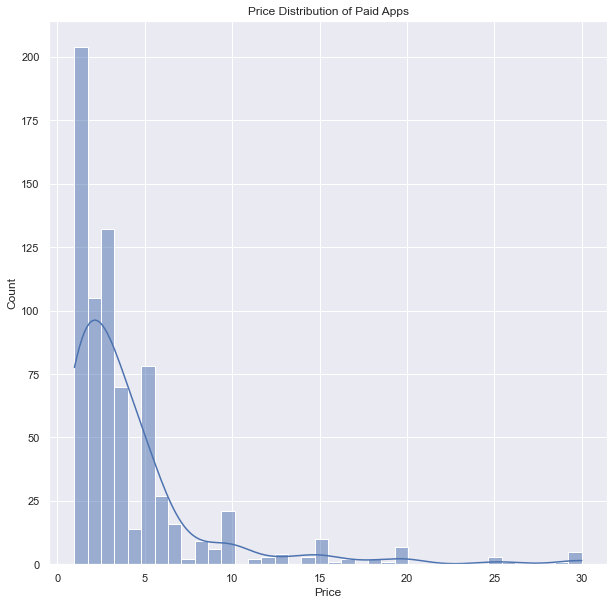

In [1027]:
plt.figure(figsize=(10,10))
paid_apps = src[(src["Type"] == "Paid") & (src["Price"] < 30)]
sns.histplot(paid_apps["Price"], kde=True)#.set(xlim = (0,20))
plt.title("Price Distribution of Paid Apps")

6. Top Most Installed Apps

<AxesSubplot:ylabel='App'>

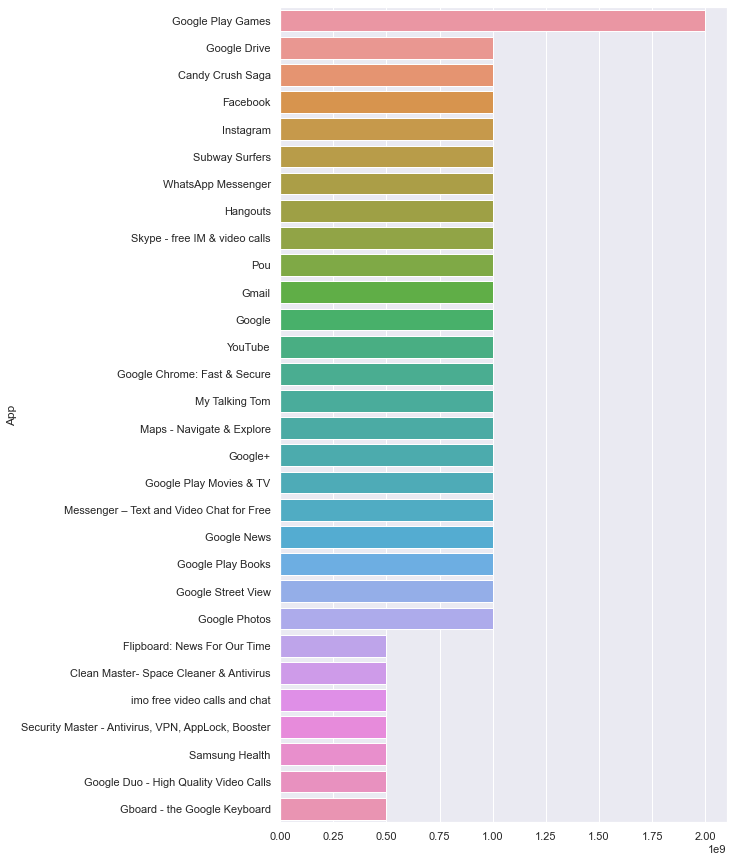

In [1028]:
most_install = src.groupby("App").Installs.sum().sort_values(ascending=False).head(30)
plt.figure(figsize=(8,15))
sns.barplot(x = most_install.values, y = most_install.index)

7. Top Reviewed App

[Text(0.5, 0, 'Number of Reviews'),
 Text(0, 0.5, 'App Name'),
 Text(0.5, 1.0, 'Top Reviewed Apps')]

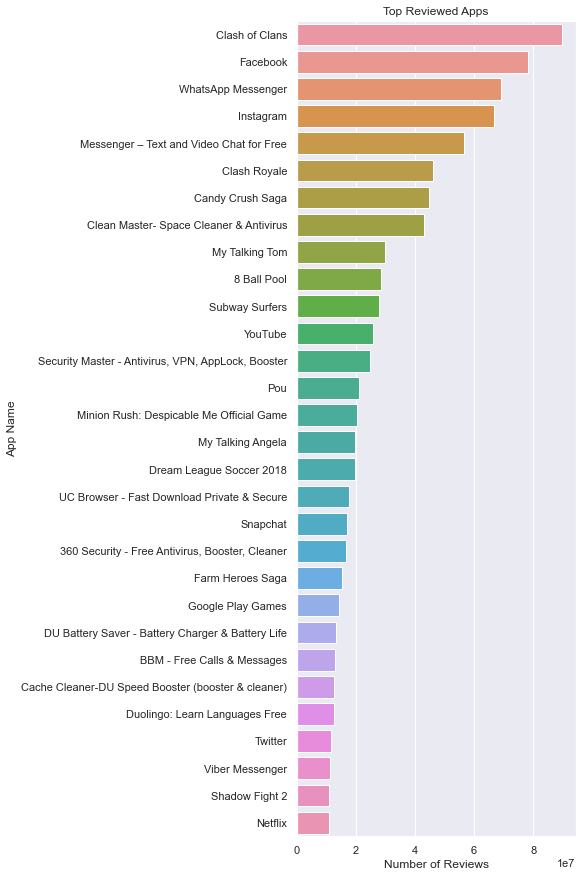

In [1029]:
plt.figure(figsize=(5,15))
most_reviewed = src.groupby("App").Reviews.sum().sort_values(ascending=False).head(30)
sns.barplot(x = most_reviewed.values, y = most_reviewed.index).set(xlabel = "Number of Reviews", ylabel = "App Name", title = "Top Reviewed Apps")

**I. CATEGORY EXPLORATION**

1. Box Plot of Ratings by Category

[Text(0.5, 1.0, 'Box Plot of Ratings in each category')]

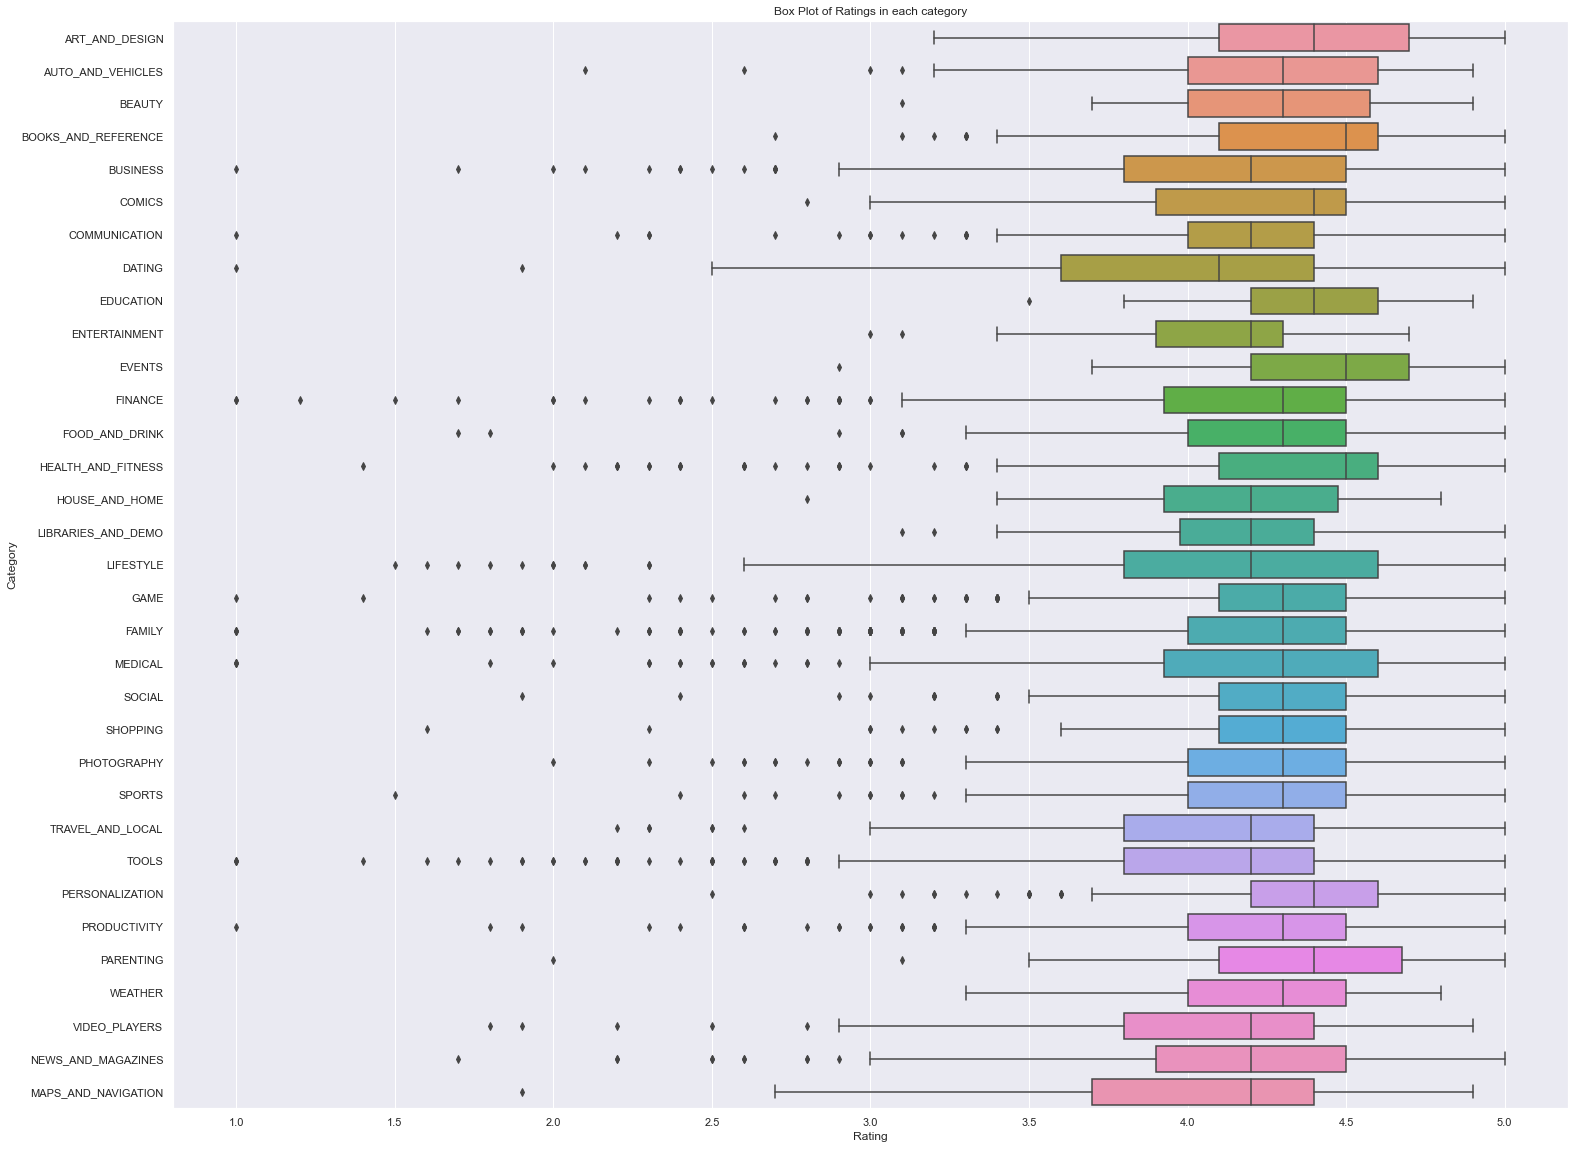

In [1030]:
sns.set(rc = {'figure.figsize':(25,20)})
sns.boxplot(y="Category",x="Rating",data = src,width=0.8).set(title = "Box Plot of Ratings in each category")

2. Most Popular Category By Installs

[Text(0.5, 0, 'Number of Installs'),
 Text(0, 0.5, 'App Category'),
 Text(0.5, 1.0, 'App Category vs Number of Installs')]

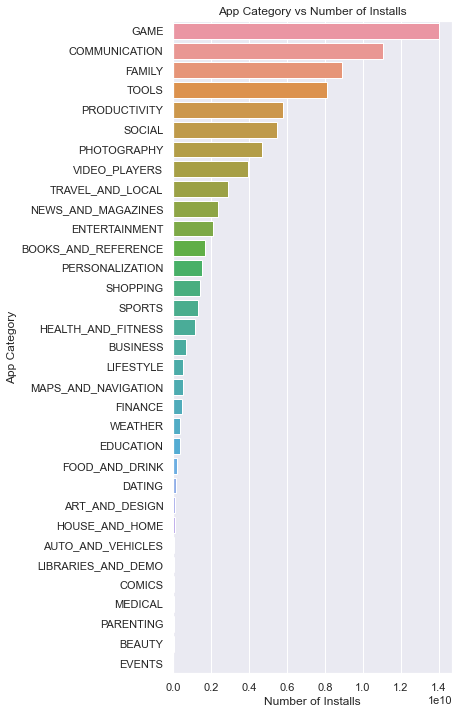

In [1031]:
plt.figure(figsize=(5, 12))
cat_installs = src.groupby("Category").Installs.sum().sort_values(ascending=False)
sns.barplot(x = cat_installs.values, y = cat_installs.index).set(xlabel = "Number of Installs", ylabel = "App Category", title = "App Category vs Number of Installs")

3. Top Rated Categories

[Text(0.5, 0, 'Mean Rating'),
 Text(0, 0.5, 'App Category'),
 Text(0.5, 1.0, 'App Vategory Vs. Mean Rating')]

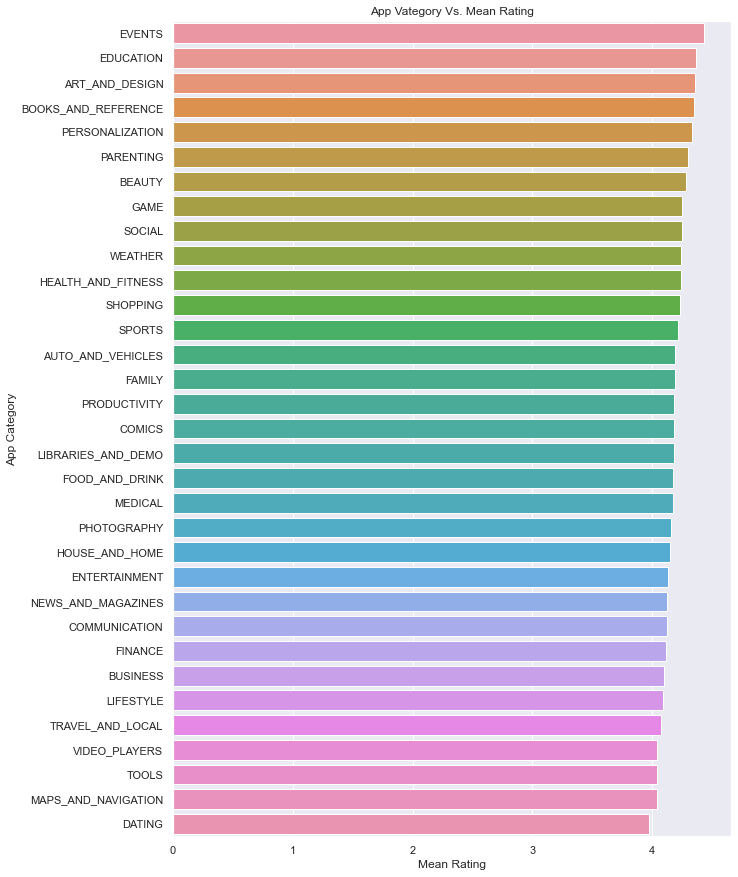

In [1032]:
plt.figure(figsize=(10, 15))
cat_rating = src.groupby("Category").Rating.mean().sort_values(ascending=False)
sns.barplot(x = cat_rating.values, y = cat_rating.index).set(xlabel = "Mean Rating", ylabel = "App Category", title = "App Vategory Vs. Mean Rating")

4. Top Reviewed Category

[Text(0, 0.5, 'App Category'),
 Text(0.5, 0, 'Mean number of Reviews'),
 Text(0.5, 1.0, 'Category vs Mean Number of Reviews')]

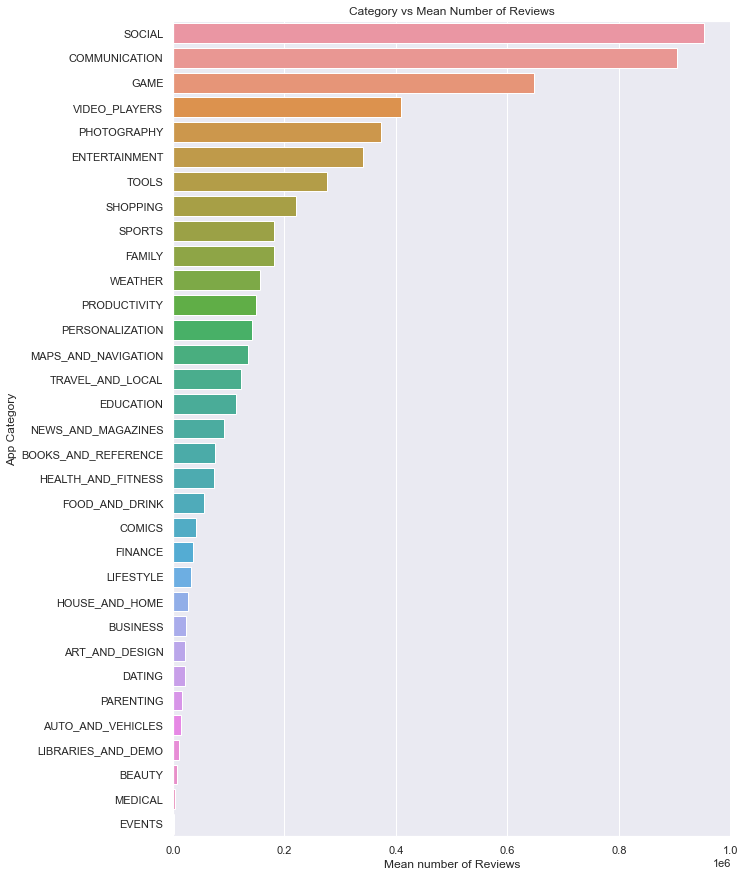

In [1033]:
plt.figure(figsize=(10, 15))
cat_review = src.groupby("Category").Reviews.mean().sort_values(ascending=False)
sns.barplot(x = cat_review.values, y = cat_review.index).set(ylabel = "App Category", xlabel = "Mean number of Reviews", title = "Category vs Mean Number of Reviews")

5. Category Distribution

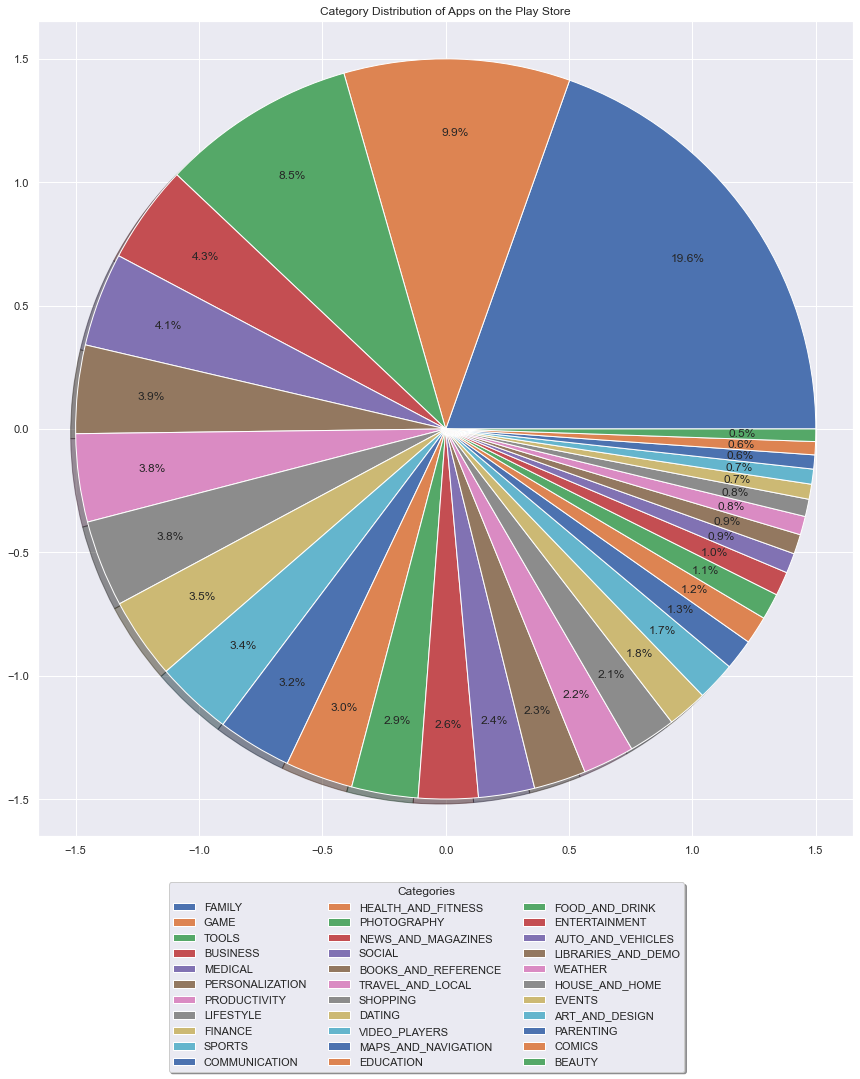

In [1034]:
plt.figure(figsize=(15,15))
cat = src.Category.value_counts()
plt.pie(cat, autopct="%.1f%%", shadow = True, radius = 1.5, frame = True, pctdistance=0.8)
plt.legend(cat.index, title = "Categories", loc="best", bbox_to_anchor=(0.8, -0.05),
          ncol=3, fancybox=True, shadow=True)
plt.title("Category Distribution of Apps on the Play Store")
plt.show()

**J. ANALYSIS: CONTENT RATING AGAINST INSTALLS AND RATING**

1. Basic Aggregation

In [1035]:
content_rating_score = src.groupby("Content Rating").aggregate({"Rating":"mean","Installs":"mean"})
content_rating_score

Rating      Installs
Content Rating                         
Adults only 18+  4.300000  6.666667e+05
Everyone         4.168179  6.928470e+06
Everyone 10+     4.231661  1.378652e+07
Mature 17+       4.121849  6.203529e+06
Teen             4.226152  1.682334e+07
Unrated          4.100000  2.525000e+04

2. Content Rating Vs. Mean Rating

[Text(0.5, 0, 'Content Rating'),
 Text(0, 0.5, 'Rating'),
 Text(0.5, 1.0, 'Content Rating Vs. Rating')]

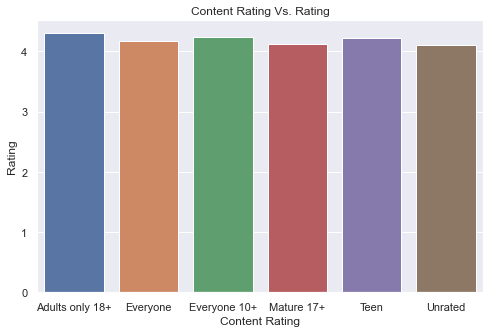

In [1036]:
plt.figure(figsize=(8,5))
sns.barplot(x = content_rating_score.index, y = content_rating_score.Rating).set(xlabel = "Content Rating", ylabel = "Rating", title = "Content Rating Vs. Rating")

3. Content Rating Vs. Installs

[Text(0.5, 0, 'Content Rating'),
 Text(0, 0.5, 'Install'),
 Text(0.5, 1.0, 'Content Rating Vs. Install')]

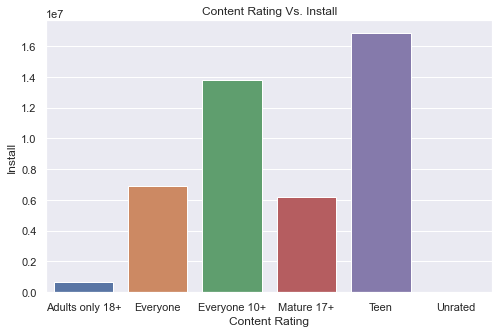

In [1037]:
plt.figure(figsize=(8,5))
sns.barplot(x = content_rating_score.index, y = content_rating_score.Installs).set(xlabel = "Content Rating", ylabel = "Install", title = "Content Rating Vs. Install")

**K. CORRELATION BETWEEN VARIABLES**

d:\Installation_Files\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

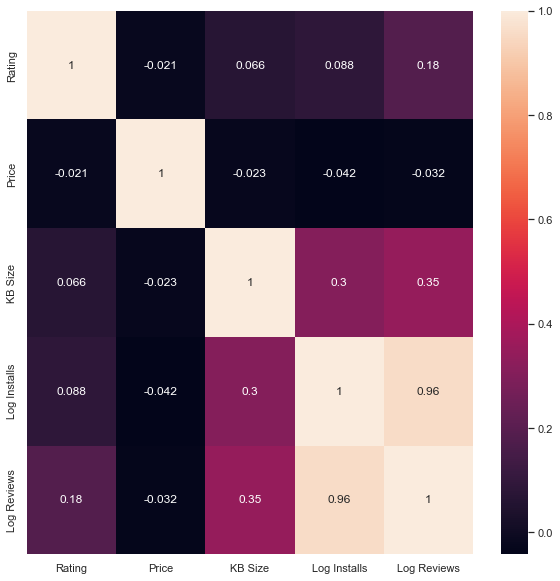

In [1038]:
src['Log Reviews']= np.log10(src['Reviews'])
src3=src.drop(['Reviews',"Installs","Months since Last Update"],axis=1,inplace=False)
src3
plt.figure(figsize=(10,10))
sns.heatmap(src3.corr(), annot=True)

**L. WORDCLOUD**

1. Positive Sentiment Overall

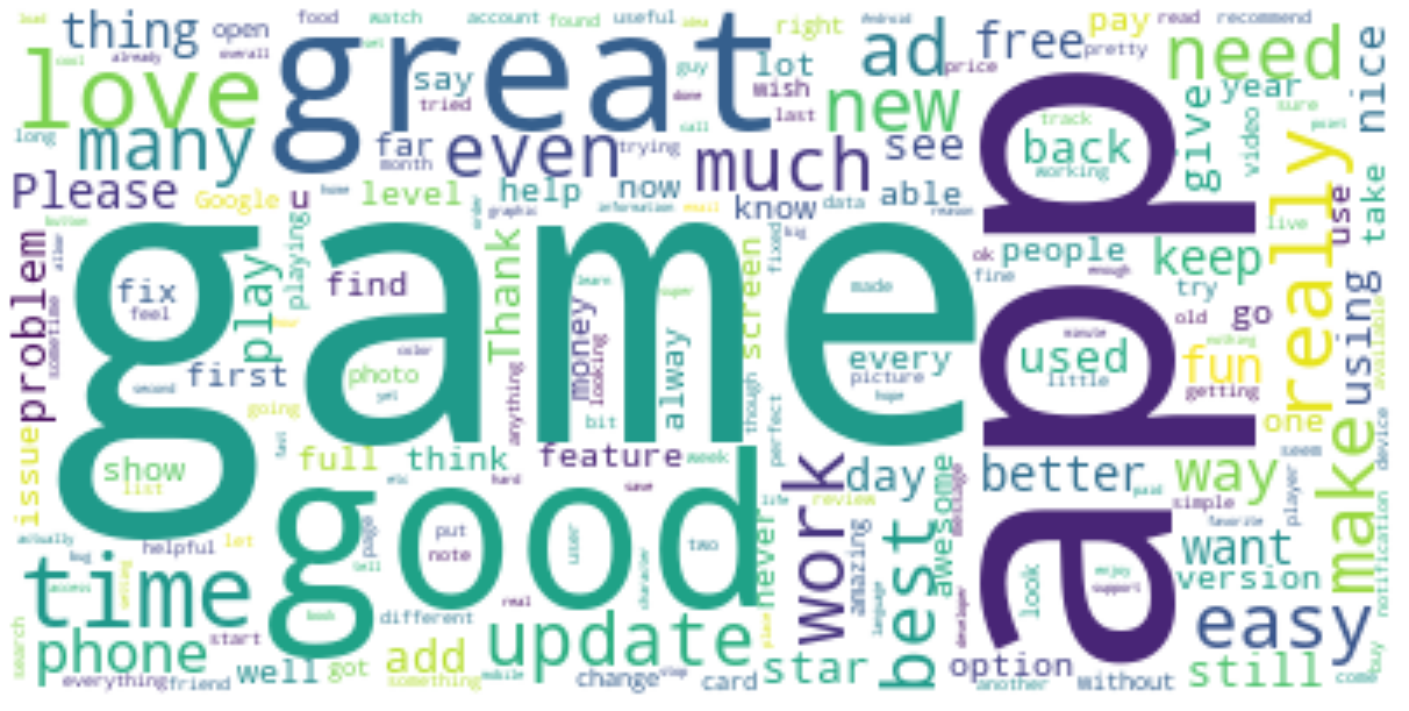

In [1039]:
#text = rvw["Translated_Review"].str.cat(new, sep =", ")
text = rvw[rvw["Sentiment"] == "Positive"].groupby(lambda x: True).agg({'Translated_Review': ''.join})
actualtext = text.loc[True].item()
#text = " ".join(cat.split()[1] for cat in rvw["Translated_Review"])
#print(text)
word_cloud = wc(collocations = False, background_color = 'white').generate(actualtext)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

2. Negative Sentiment on Games

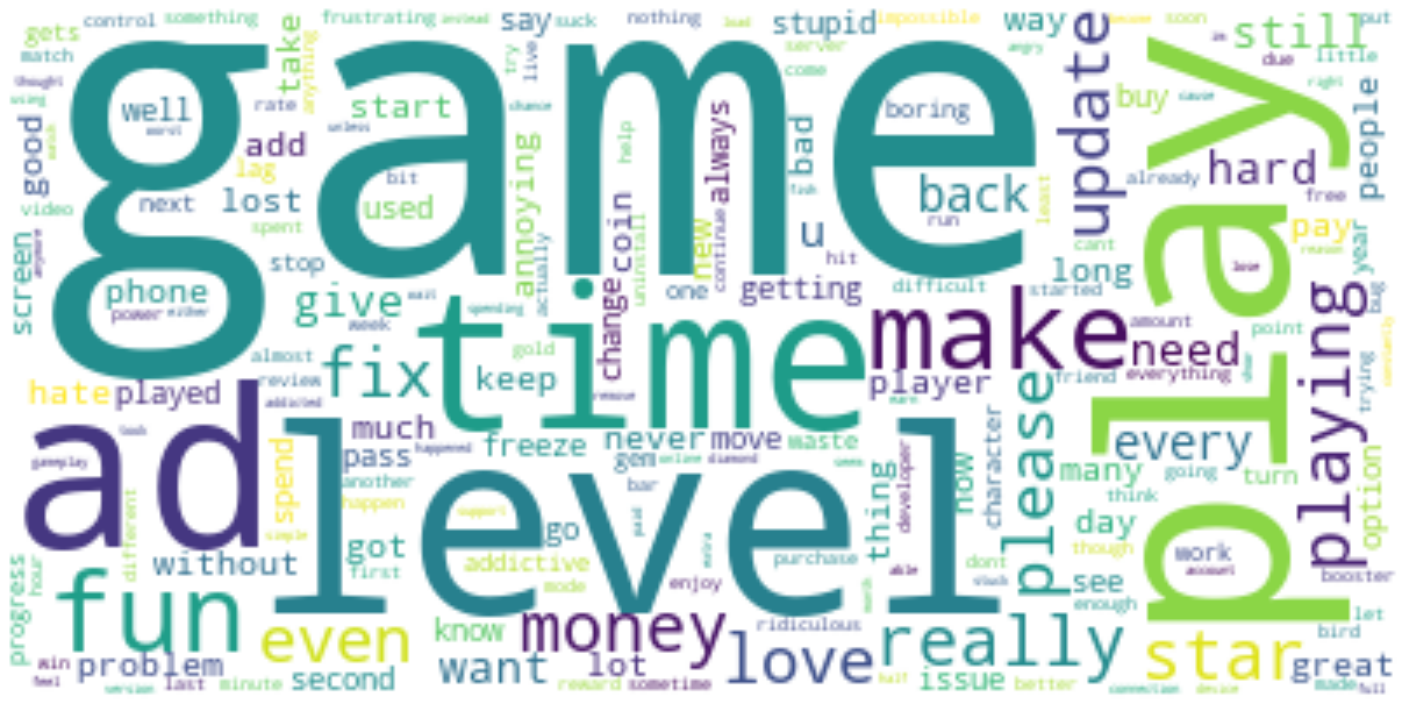

In [1040]:
mergedrvw = rvw.merge(src, how = 'inner',on = 'App',suffixes = ["-rvw","src"])
gamers = mergedrvw[mergedrvw["Category"] == "GAME"]
text = gamers[gamers["Sentiment"] == "Negative"].groupby(lambda x: True).agg({'Translated_Review': ''.join})
actualtext = text.loc[True].item()

word_cloud = wc(collocations = False, background_color = 'white').generate(actualtext)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

3. Positive Sentiment on Games

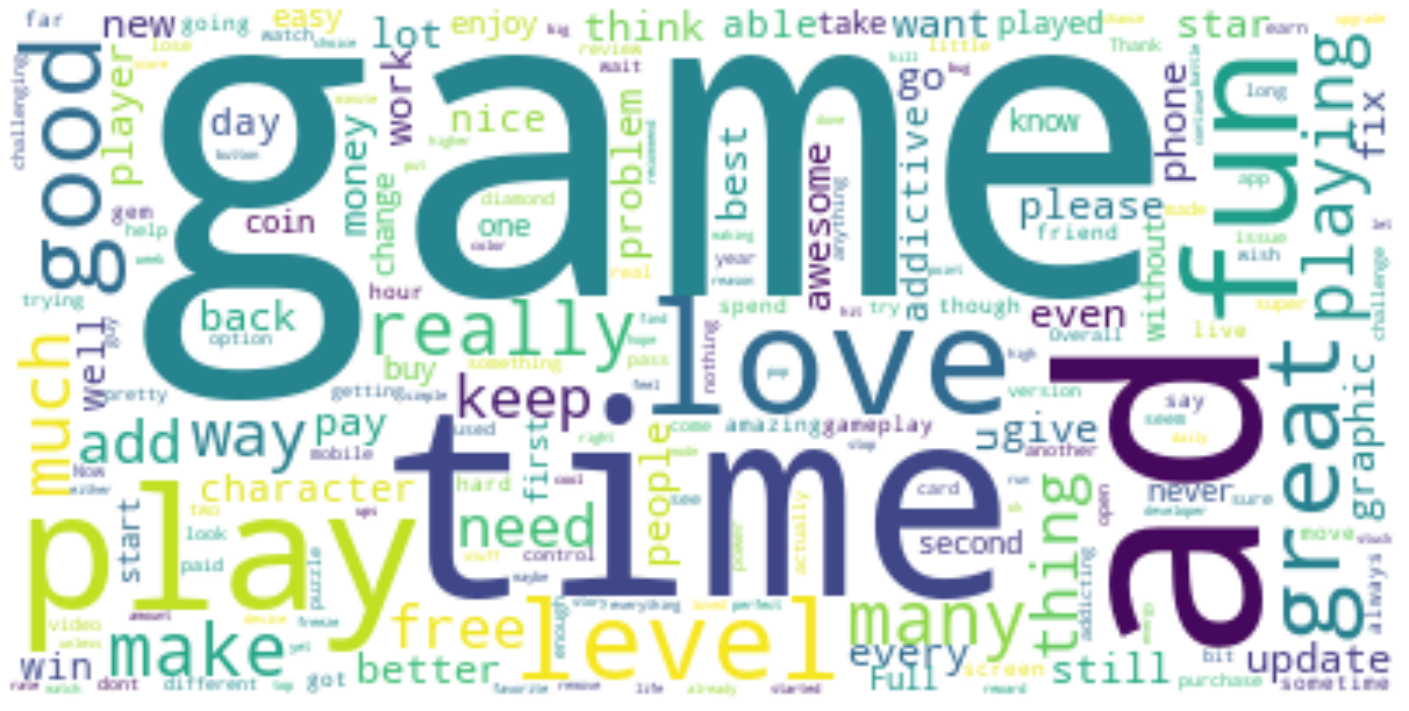

In [1041]:
text = gamers[gamers["Sentiment"] == "Positive"].groupby(lambda x: True).agg({'Translated_Review': ''.join})
actualtext = text.loc[True].item()

word_cloud = wc(collocations = False, background_color = 'white').generate(actualtext)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

4. Positive Sentiment on everything but Games

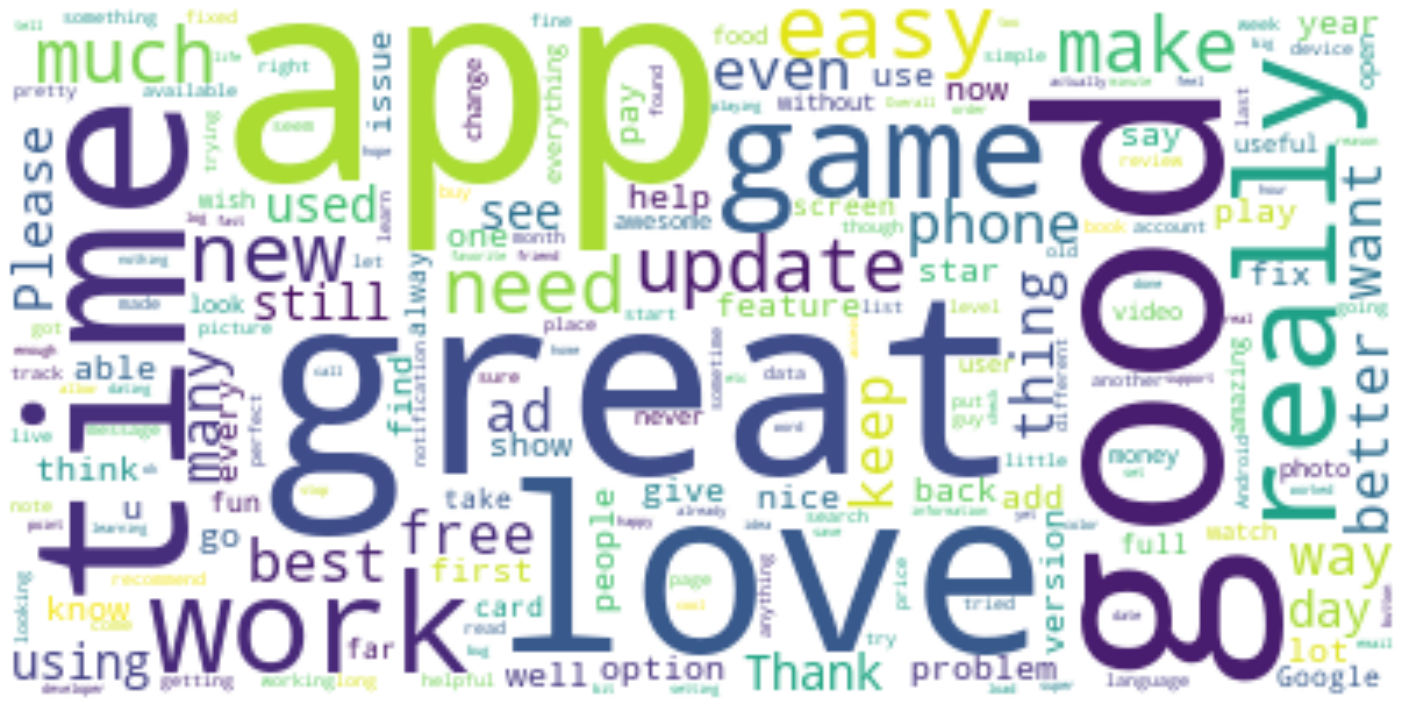

In [1042]:
nongamers = mergedrvw[mergedrvw["Category"] != "GAME"]
text = nongamers[nongamers["Sentiment"] == "Positive"].groupby(lambda x: True).agg({'Translated_Review': ''.join})
actualtext = text.loc[True].item()
word_cloud = wc(collocations = False, background_color = 'white').generate(actualtext)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

5. Negative Sentiment on everything but Games

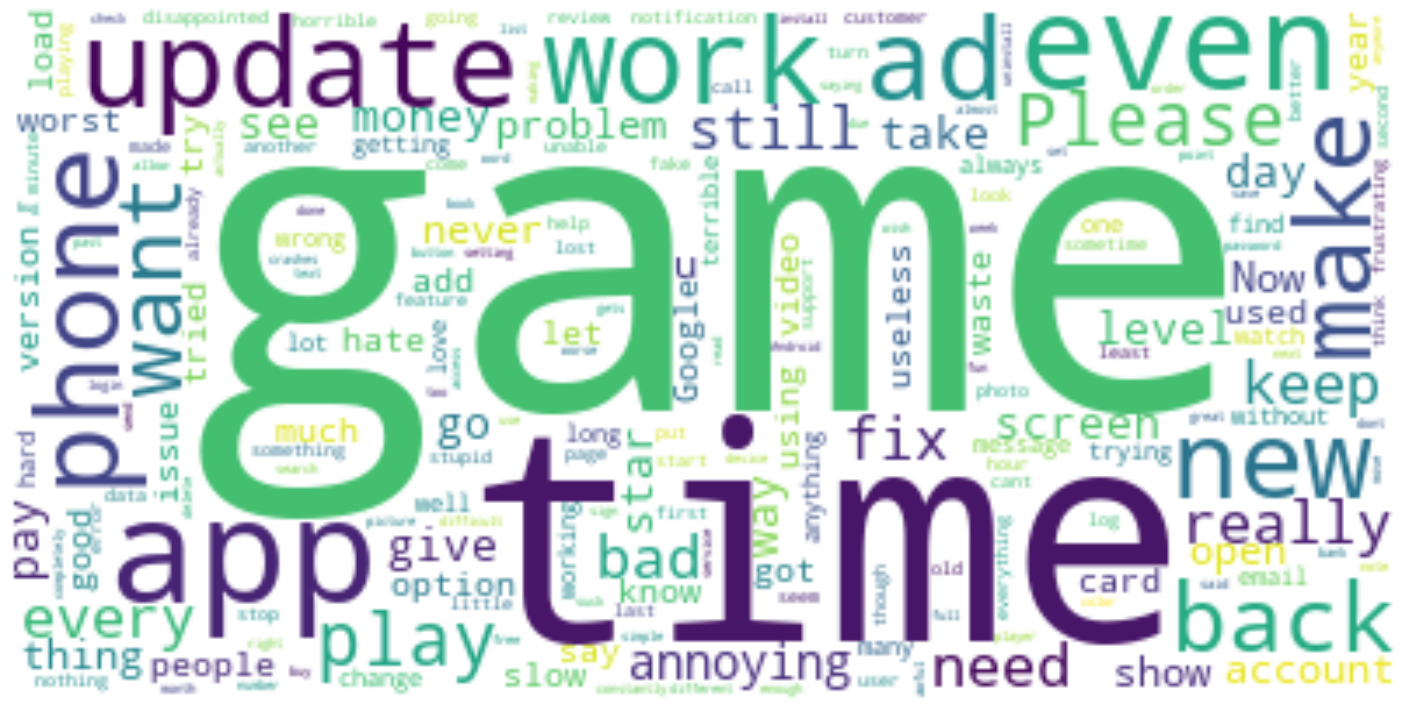

In [1043]:
text = nongamers[nongamers["Sentiment"] == "Negative"].groupby(lambda x: True).agg({'Translated_Review': ''.join})
actualtext = text.loc[True].item()
word_cloud = wc(collocations = False, background_color = 'white').generate(actualtext)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()